In [1]:
# load libs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

In [2]:
# definition of a simple fc model [2, 32, 64, 1]
class MOGANet(nn.Module):
    def __init__(self):
        super(MOGANet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

class MOGADataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

In [3]:
# define train and test functions
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        # compute output
        outputs = model(x)
        loss = criterion(outputs, y)
        train_loss += loss.item()
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    return train_loss

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            
            # compute output
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item()
            
    test_loss /= len(test_loader)
    return test_loss

In [4]:
# Use CUDA
device = torch.device("cpu")

random.seed(2020) 
torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)

# load files
moga = pickle.load(open("moga.0203.pkl", "rb"))
x_train, x_test = moga["x_train"], moga["x_test"]
y_train, y_test = moga["y_train"], moga["y_test"]
x_mean, x_std = moga["x_mean"], moga["x_std"]

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()

In [5]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 4}

# dataloader
train_data = MOGADataset(x_train, y_train)
train_loader = DataLoader(dataset=train_data, **params)

test_data = MOGADataset(x_test, y_test)
test_loader = DataLoader(dataset=test_data, **params)

In [6]:
model = MOGANet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

In [7]:
# Training here
for t in range(500):
    train_loss = train(model, device, train_loader, optimizer, criterion) 
    test_loss = test(model, device, test_loader, criterion)
    if t%10 == 0:
        print(t, train_loss, test_loss)
    
    scheduler.step(test_loss)

0 214900.7722939597 6907.966853383252
10 427.7645770540927 430.55339350785744
20 370.88494488404336 380.15869460630296
30 348.8338858518399 350.260547959896
40 339.1858156561775 335.8534088525016
50 328.9967548372802 328.3622290569803
60 320.96744372855375 318.5830489058629
70 316.87047507102415 321.39886974129837
80 314.50290475407246 316.11563176694125
90 313.4117554257638 332.77822942319125
100 311.81051018752123 310.5206064677909
110 310.5181230678058 308.9691210110169
120 305.81201937255076 312.54780851788536
130 305.25086395205096 305.0913718533333
140 302.83034898559026 304.3519323402658
150 302.2444958824114 302.6499821499485
160 301.1706103265705 302.2883201267408
170 301.0588080857095 301.80157872660993
180 300.7491135453842 301.5747495685392
190 300.589775373443 301.3481330188644
200 300.50399047109613 302.9345127115469
210 299.8665379422335 301.01805181088656
220 299.81215936681514 300.6061288194583
230 299.5918574708437 300.44709762222016
240 299.41721815034816 300.3696422

In [9]:
# save trained model
torch.save(model.state_dict(), 'moga-0203.pth')
#model.load_state_dict(torch.load("moga-0203.pth"))

In [10]:
model.eval()
Yp = model(x_test)
print("test MSE from criterion")
MSE = criterion(Yp, y_test).item()
print(MSE)

Yp = Yp[:,0].detach().numpy()
y_test = y_test[:,0].detach().numpy()

delta_y = Yp - y_test
RMSE = np.sqrt(MSE)
print("test RMSE of original data")
print(RMSE)

test MSE from criterion
300.3089904785156
test RMSE of original data
17.32942556689389


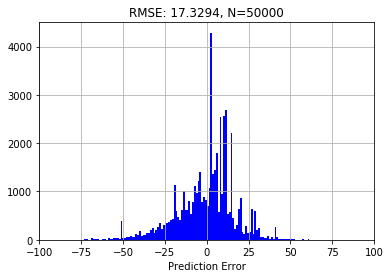

In [12]:
# plot RMSE
plt.figure(figsize=(6,4))
num_bins = 200
plt.hist(delta_y, num_bins, facecolor='blue')
plt.xlabel('Prediction Error')
plt.xlim(-100,100)
plt.grid(True)
plt.title('RMSE: %.4f, N=%d' % (RMSE,len(x_test)))
plt.show()

In [13]:
# check mean ans std
print(np.std(y_test))
print(np.mean(y_test))
print(max(y_test), min(y_test))

112.775635
-944.71313
0.0 -1015.97565


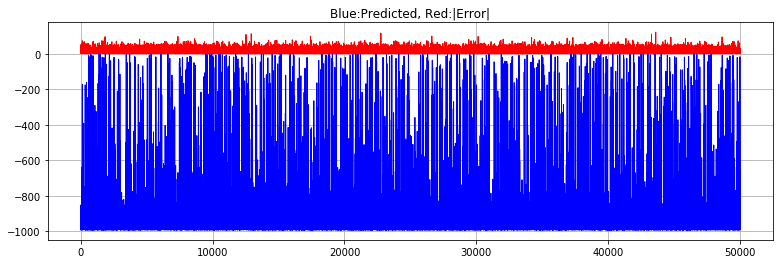

In [14]:
# Viz Yp and |Error|
l = np.array([x for x in range(len(y_test))])
plt.figure(figsize=(13,4))
plt.title("Blue:Predicted, Red:|Error|")
plt.plot(l, Yp, 'b-', linewidth=1)
plt.plot(l, abs(delta_y), 'r-', linewidth=1)
plt.grid(True)
plt.show()

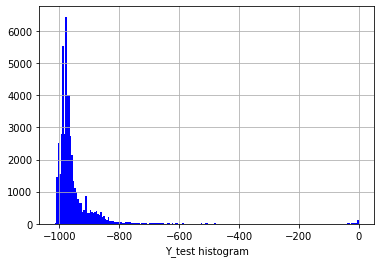

In [15]:
# Viz y_test hist
plt.figure(figsize=(6,4))
num_bins = 200
plt.hist(y_test, num_bins, facecolor='blue')
plt.xlabel('Y_test histogram')
plt.grid(True)
plt.show()